In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.12.0


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7
TRAIN_PATH = '/kaggle/input/aptos2019-blindness-detection/train_images'
TEST_PATH = '/kaggle/input/aptos2019-blindness-detection/test_images'

DF_TRAIN = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv', dtype='str')
DF_TRAIN['image_path'] = DF_TRAIN["id_code"] + ".png"
TEST_IMAGES = glob.glob(TEST_PATH + '/*.png')
DF_TEST = pd.DataFrame(TEST_IMAGES, columns = ['image_path'])

classes = {0 : "No DR",
           1 : "Mild",
           2 : "Moderate",
           3 : "Severe",
           4 : "Proliferative"}


In [3]:
DF_TRAIN.head()

,id_code,diagnosis,image_path
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    #p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    #image =tf.image.random_flip_left_right(image)
    #image =tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
  #Rotates
  #if p_rotate > .75:
    #image = tf.image.rot90(image, k = 3) # rotate 270°
  #if p_rotate > .5:
    #image = tf.image.rot90(image, k = 2) # rotate 180°
 #if p_rotate > .25:
    #image = tf.image.rot90(image, k = 1) # rotate 90°
    
  #pixel_level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)

    return image
    

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                         samplewise_center = True,
                                                         samplewise_std_normalization = True,
                                                         validation_split = 0.2,
                                                         preprocessing_function = data_augment)

train_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                       directory = TRAIN_PATH,
                                       x_col = 'image_path',
                                       y_col = 'diagnosis',
                                       subset = 'training',
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = True,
                                       class_mode = 'categorical',
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))
valid_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                       directory = TRAIN_PATH,
                                       x_col = 'image_path',
                                       y_col = 'diagnosis',
                                       subset = 'validation',
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = 'categorical',
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))
test_gen = datagen.flow_from_dataframe(dataframe = DF_TEST,
                                       #directory = TRAIN_PATH
                                       x_col = 'image_path',
                                       y_col = None,
                                       #subset = 'validation',
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


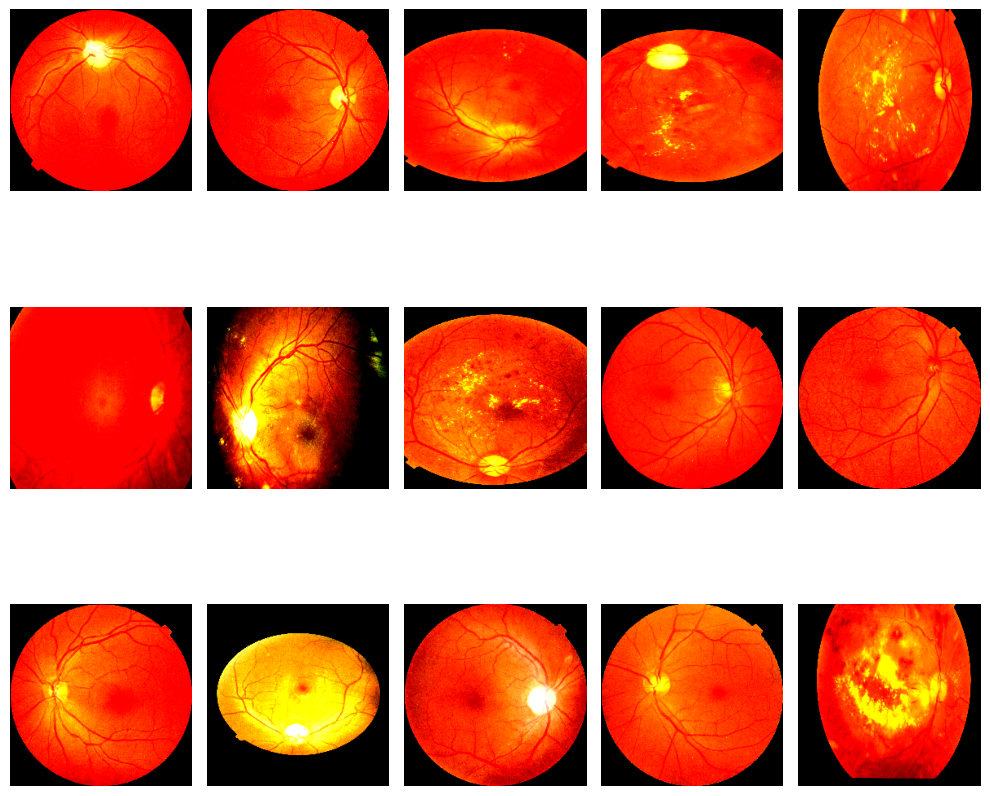

In [6]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes .flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')
    
plt.tight_layout()
plt.show()


In [7]:
!pip install --quiet vit-keras
  
from vit_keras import vit 

In [8]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

353253686/353253686 [==============================] - 6s 0us/step


1/1 [==============================] - 2s 2s/step


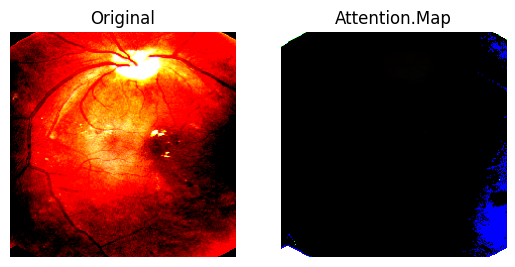

In [9]:
from vit_keras import visualize

x = test_gen.next()
image = x[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

#Plot results 
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention.Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)




In [10]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 5)          

In [11]:
model_b = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model_b.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 layer_normalization (LayerN  (None, 768)              1536      
 ormalization)                                                   
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 11)                8459      
                                                                 
 batch_normalization_3 (Batc  (None, 11)        

In [12]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
             loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
             metrics = ['accuracy'])
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                factor = 0.2,
                                                patience = 2,
                                                verbose = 1,
                                                min_delta = 1e-4,
                                                min_lr = 1e-6,
                                                mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                min_delta = 1e-4,
                                                patience = 5,
                                                mode = 'max',
                                                restore_best_weights = True,
                                                verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                 monitor = 'val_accuracy',
                                                 verbose = 1,
                                                 save_best_only = True,
                                                 save_weights_only = True,
                                                 mode = 'max')
callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
         steps_per_epoch = STEP_SIZE_TRAIN,
         validation_data = valid_gen,
         validation_steps = STEP_SIZE_VALID,
         epochs = EPOCHS,
         callbacks = callbacks)

Epoch 1/7
183/183 [==============================] - ETA: 0s - loss: 1.4571 - accuracy: 0.5100
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to ./model.hdf5
183/183 [==============================] - 755s 4s/step - loss: 1.4571 - accuracy: 0.5100 - val_loss: 1.1603 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/7
183/183 [==============================] - ETA: 0s - loss: 1.1492 - accuracy: 0.7172
Epoch 2: val_accuracy did not improve from 0.75000
183/183 [==============================] - 723s 4s/step - loss: 1.1492 - accuracy: 0.7172 - val_loss: 1.1403 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 3/7
183/183 [==============================] - ETA: 0s - loss: 1.1157 - accuracy: 0.7375
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 3: val_accuracy did not improve from 0.75000
183/183 [==============================] - 713s 4s/step - loss: 1.1157 - accuracy: 0.7375 - val_loss: 1.1440 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 

In [13]:
model.load_weights("./model.hdf5")

In [14]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 5)          

In [15]:
model.get_layer("vit-b32").summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

46/46 [==============================] - 80s 2s/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       337
           1       0.54      0.65      0.59        77
           2       0.66      0.79      0.72       221
           3       0.50      0.11      0.17        38
           4       0.67      0.24      0.35        59

    accuracy                           0.78       732
   macro avg       0.66      0.55      0.56       732
weighted avg       0.77      0.78      0.76       732



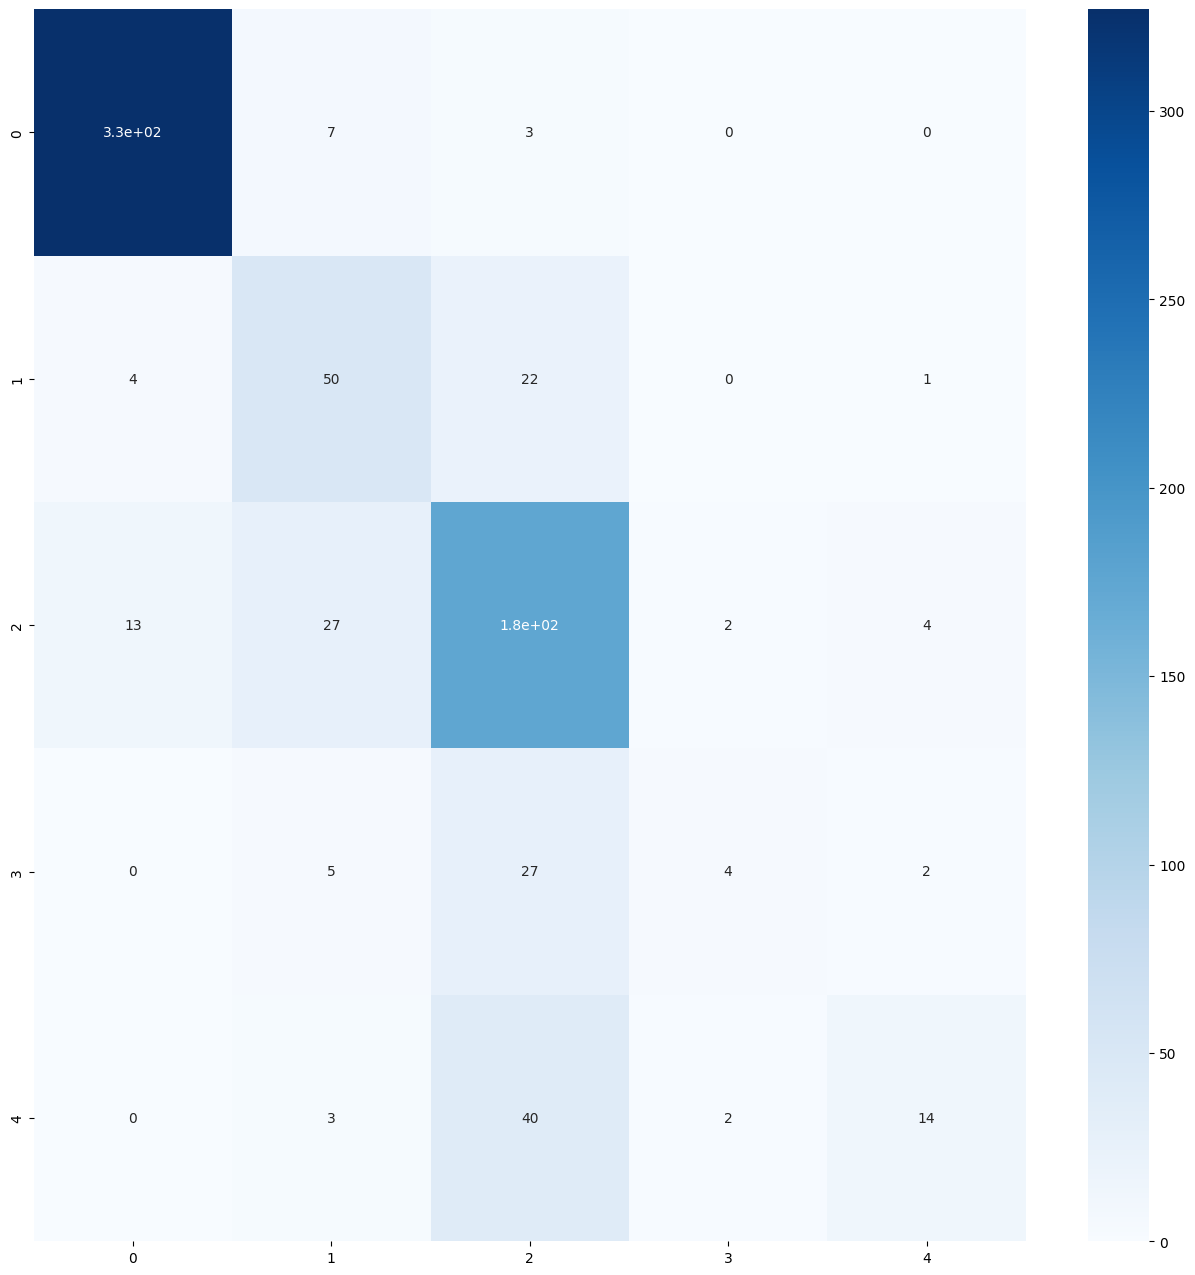

In [16]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

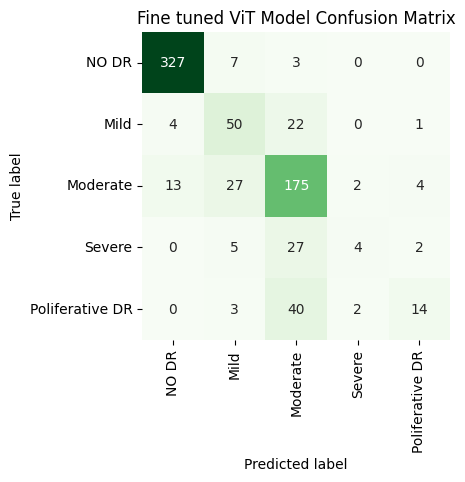

In [17]:
# Creates a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['NO DR', 'Mild','Moderate','Severe', 'Poliferative DR'],
                     columns = ['NO DR', 'Mild','Moderate','Severe', 'Poliferative DR'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, square=True, annot=True, cmap='Greens', fmt='d' , cbar=False)
plt.title('Fine tuned ViT Model Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
